<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/ships_tanz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation on aeriel ship images - based on CamVid example


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
#according to error
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [53]:
## paths for AWS

DATA_DIR = Path('/home/ubuntu/data/ships_med/')


path_lbl = DATA_DIR/'label'
path_img = DATA_DIR/'Train'

In [0]:
DATA_DIR = Path('/content/data/ships_mini/')
DATA_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
print( gpu_mem_get() )

GPUMemory(total=11441, free=11430, used=11)


### Get training Data From Drive

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')


#### Utilities for Managing Files on Google Drive

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records



### create folders and download data

In [7]:
train_file_name = 'ships_mini.zip'
label_file_name = 'train_ship_segmentations_v2.csv'
codes_file_name = 'ship_codes.txt'

train_drive_file_id = get_file_id(train_file_name)
label_drive_file_id = get_file_id(label_file_name)
codes_drive_file_id = get_file_id(codes_file_name)

move_from_drive_to_disk([train_file_name], [DATA_DIR/train_file_name])
move_from_drive_to_disk([label_file_name], [DATA_DIR/label_file_name])
move_from_drive_to_disk([codes_file_name], [DATA_DIR/codes_file_name])

#!find '/content/' -type f -name \*.jpg -delete

Downloaded 72913034/72913034 bytes
Downloaded 45093109/45093109 bytes
Downloaded 13/13 bytes


In [0]:
!unzip -o {DATA_DIR}'/ships_mini.zip' -d {DATA_DIR}'/Train/'
#!unzip -o {DATA_DIR}'/train_ship_segmentations_v2.csv.zip' -d {DATA_DIR}

In [0]:
!ls {DATA_DIR}'/Train/' | wc -l

501


In [0]:
#path_img = str(DATA_DIR/'Train')

path_lbl = DATA_DIR/'label'
path_img = DATA_DIR/'Train'

In [16]:
label_df_raw = pd.read_csv(f'{DATA_DIR}/train_ship_segmentations_v2.csv', low_memory=False )
label_df_raw = label_df_raw.replace(np.nan, '', regex=True)

In [17]:
pd.set_option("display.max_colwidth", 10000)

## Move some ship files to valid.txt 


In [ ]:
#ship_files = os.listdir( '/home/ubuntu/data/ships_med/train' )
ship_files = os.listdir(str(DATA_DIR) + '/train')


In [32]:
valid_ships = ship_files[:300]

In [34]:
with open(str(DATA_DIR) + '/valid.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(valid_ships))

In [35]:
#!ls {DATA_DIR}
!cat {DATA_DIR}/'valid.txt' | wc -l

299


### make dataframe of rle data for masks

In [36]:
#ship_files = os.listdir('data/ships_mini/Train')
def in_mini(f):
  return f['ImageId'] in ship_files
masks = label_df_raw[label_df_raw.apply(in_mini, axis=1)]
masks.shape, label_df_raw.shape



((11892, 2), (231723, 2))

In [37]:
#merge mask df on image id
masks = masks.groupby('ImageId')['EncodedPixels'].apply(lambda x: ' '.join(x)).reset_index()
masks.shape

(10000, 2)

## Write masks to jpgs in /labels

In [43]:
#!rm -rf {DATA_DIR}/label
#!mkdir {DATA_DIR}/label
!ls {DATA_DIR}

label  train  train_ship_segmentations_v2.csv  valid.txt


In [47]:

dmasks = masks.to_dict()
#for r in range(2,5):

for r in range(8440, len( dmasks['ImageId'])):
    try:
        image_id = dmasks['ImageId'][r]
        filename = str( DATA_DIR/'label') + '/' + image_id
        rle_0 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels'].to_string(index=False)
        rle_mask = open_mask_rle( rle_0, [768,768])
        rle_mask = rle_mask.rotate(-90).flip_lr() 
        rle_mask.save( DATA_DIR/'label/{}'.format(image_id).replace('jpg','png') )
    except:
        print( 'bad mask ... removing ', str(DATA_DIR) + '/Train/' + image_id )
        os.remove(str(DATA_DIR) + '/Train/' + image_id)
  #mask_reopen = open_mask( get_y_fn( image_id ))
  #print( 'after reopening ', max( list(mask_reopen.data.view(-1)) ))

bad mask ... removing  /home/ubuntu/data/ships_med/train/d88b769af.jpg


In [57]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3]

([PosixPath('/home/ubuntu/data/ships_med/Train/24e5ee4af.jpg'),
  PosixPath('/home/ubuntu/data/ships_med/Train/06cb32197.jpg'),
  PosixPath('/home/ubuntu/data/ships_med/Train/8e6de0b0e.jpg')],
 [PosixPath('/home/ubuntu/data/ships_med/label/a8be62037.png'),
  PosixPath('/home/ubuntu/data/ships_med/label/35be32f35.png'),
  PosixPath('/home/ubuntu/data/ships_med/label/35c002c07.png')])

In [63]:
def get_y_fn(y):
    s =  str( DATA_DIR/'label/') + '/'+ str(y).replace(str(DATA_DIR) + '/Train/','') 
    #print( 'get y ', s, s.replace('jpg','png') )
    return s.replace('jpg','png')

/home/ubuntu/data/ships_med/Train/bb970a3e1.jpg


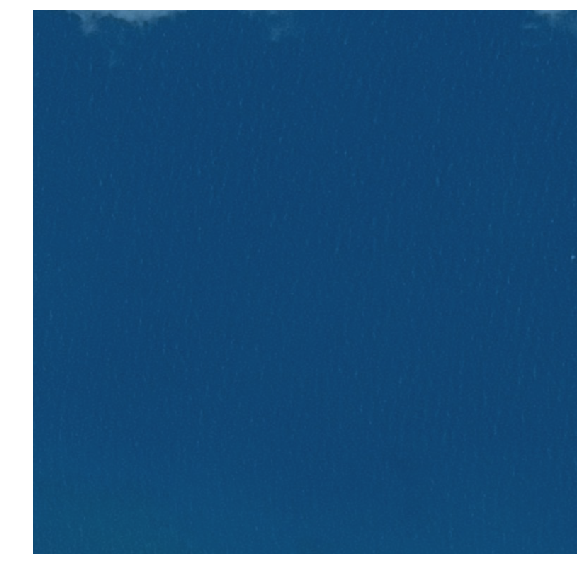

In [64]:
img_f = fnames[-4]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [65]:

src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[768 768]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

## Data - load w/ datablock api

In [67]:

size = src_size//4
size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")
bs=4
codes = np.loadtxt(DATA_DIR/'codes.txt', dtype=str); codes

array(['NotShip', 'Ship'], dtype='<U7')

In [68]:

# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom

In [69]:

src = (SegItemListCustom.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

/home/ubuntu/data/ships_med/Train/33d2fee7a.jpg
/home/ubuntu/data/ships_med/Train/6f7b3404b.jpg
/home/ubuntu/data/ships_med/Train/dde767f2d.jpg
/home/ubuntu/data/ships_med/Train/fb3201523.jpg
/home/ubuntu/data/ships_med/Train/ca6e2400b.jpg
/home/ubuntu/data/ships_med/Train/5c9e875e2.jpg
/home/ubuntu/data/ships_med/Train/1e5bbb992.jpg
/home/ubuntu/data/ships_med/Train/0594d535b.jpg
/home/ubuntu/data/ships_med/Train/4cceff190.jpg
/home/ubuntu/data/ships_med/Train/90873e810.jpg
/home/ubuntu/data/ships_med/Train/cabd37086.jpg
/home/ubuntu/data/ships_med/Train/39f33bba9.jpg
/home/ubuntu/data/ships_med/Train/152bf9730.jpg
/home/ubuntu/data/ships_med/Train/8604b418c.jpg
/home/ubuntu/data/ships_med/Train/072ed6b55.jpg
/home/ubuntu/data/ships_med/Train/c0a4cbf06.jpg
/home/ubuntu/data/ships_med/Train/7e48cba82.jpg
/home/ubuntu/data/ships_med/Train/65f778c87.jpg
/home/ubuntu/data/ships_med/Train/3f77ec6de.jpg
/home/ubuntu/data/ships_med/Train/495401c76.jpg
/home/ubuntu/data/ships_med/Train/adf8f0

/home/ubuntu/data/ships_med/Train/42d5923d6.jpg
/home/ubuntu/data/ships_med/Train/3a8ff56fc.jpg
/home/ubuntu/data/ships_med/Train/5e4ac34a5.jpg
/home/ubuntu/data/ships_med/Train/1f902e364.jpg
/home/ubuntu/data/ships_med/Train/c816a17dd.jpg
/home/ubuntu/data/ships_med/Train/3f5a496c5.jpg
/home/ubuntu/data/ships_med/Train/3000a457f.jpg
/home/ubuntu/data/ships_med/Train/644939901.jpg
/home/ubuntu/data/ships_med/Train/1b4bf2c5d.jpg
/home/ubuntu/data/ships_med/Train/65c7bd856.jpg
/home/ubuntu/data/ships_med/Train/af3497479.jpg
/home/ubuntu/data/ships_med/Train/507faca1b.jpg
/home/ubuntu/data/ships_med/Train/c21118825.jpg
/home/ubuntu/data/ships_med/Train/99317c88a.jpg
/home/ubuntu/data/ships_med/Train/c3bc64d0d.jpg
/home/ubuntu/data/ships_med/Train/3781ea911.jpg
/home/ubuntu/data/ships_med/Train/86ff2900e.jpg
/home/ubuntu/data/ships_med/Train/6395816b9.jpg
/home/ubuntu/data/ships_med/Train/63f8519fe.jpg
/home/ubuntu/data/ships_med/Train/bd1ee3297.jpg
/home/ubuntu/data/ships_med/Train/d9a43f

/home/ubuntu/data/ships_med/Train/3957cc3d3.jpg
/home/ubuntu/data/ships_med/Train/f7668b56a.jpg
/home/ubuntu/data/ships_med/Train/e245c0a4c.jpg
/home/ubuntu/data/ships_med/Train/df8fd494a.jpg
/home/ubuntu/data/ships_med/Train/2657178fe.jpg
/home/ubuntu/data/ships_med/Train/a9ec00032.jpg
/home/ubuntu/data/ships_med/Train/28947d55d.jpg
/home/ubuntu/data/ships_med/Train/24498dcf3.jpg
/home/ubuntu/data/ships_med/Train/e55ee736a.jpg
/home/ubuntu/data/ships_med/Train/83e3646dd.jpg
/home/ubuntu/data/ships_med/Train/d83338907.jpg
/home/ubuntu/data/ships_med/Train/08d6e6d41.jpg
/home/ubuntu/data/ships_med/Train/2613f7cd9.jpg
/home/ubuntu/data/ships_med/Train/d9e5ac034.jpg
/home/ubuntu/data/ships_med/Train/79aba36b0.jpg
/home/ubuntu/data/ships_med/Train/429654c36.jpg
/home/ubuntu/data/ships_med/Train/e3d3cfd96.jpg
/home/ubuntu/data/ships_med/Train/ee7d2543e.jpg
/home/ubuntu/data/ships_med/Train/3787f833b.jpg
/home/ubuntu/data/ships_med/Train/a42bfa12b.jpg
/home/ubuntu/data/ships_med/Train/a855d3

/home/ubuntu/data/ships_med/Train/6908adcd6.jpg
/home/ubuntu/data/ships_med/Train/a612ecd53.jpg
/home/ubuntu/data/ships_med/Train/70711fa7f.jpg
/home/ubuntu/data/ships_med/Train/dbda62f27.jpg
/home/ubuntu/data/ships_med/Train/4e45282a4.jpg
/home/ubuntu/data/ships_med/Train/d0cff1683.jpg
/home/ubuntu/data/ships_med/Train/e7c728e1d.jpg
/home/ubuntu/data/ships_med/Train/997408132.jpg
/home/ubuntu/data/ships_med/Train/7511c4080.jpg
/home/ubuntu/data/ships_med/Train/1635eec48.jpg
/home/ubuntu/data/ships_med/Train/147185598.jpg
/home/ubuntu/data/ships_med/Train/e9a1fafbd.jpg
/home/ubuntu/data/ships_med/Train/b4b320634.jpg
/home/ubuntu/data/ships_med/Train/a79a87a4f.jpg
/home/ubuntu/data/ships_med/Train/25bd2de06.jpg
/home/ubuntu/data/ships_med/Train/a1d1f20b0.jpg
/home/ubuntu/data/ships_med/Train/0ecb99386.jpg
/home/ubuntu/data/ships_med/Train/99016248b.jpg
/home/ubuntu/data/ships_med/Train/905dc6e6f.jpg
/home/ubuntu/data/ships_med/Train/9c8ac1cc7.jpg
/home/ubuntu/data/ships_med/Train/8d4d84

/home/ubuntu/data/ships_med/Train/4c8414347.jpg
/home/ubuntu/data/ships_med/Train/a1171ec09.jpg
/home/ubuntu/data/ships_med/Train/235157e85.jpg
/home/ubuntu/data/ships_med/Train/509208202.jpg
/home/ubuntu/data/ships_med/Train/5180890c3.jpg
/home/ubuntu/data/ships_med/Train/86c1e3858.jpg
/home/ubuntu/data/ships_med/Train/3d077d28f.jpg
/home/ubuntu/data/ships_med/Train/d5946cfb5.jpg
/home/ubuntu/data/ships_med/Train/89c88be49.jpg
/home/ubuntu/data/ships_med/Train/0fb55e414.jpg
/home/ubuntu/data/ships_med/Train/87804d7fb.jpg
/home/ubuntu/data/ships_med/Train/cc29f5d0c.jpg
/home/ubuntu/data/ships_med/Train/812992c95.jpg
/home/ubuntu/data/ships_med/Train/49cab1bda.jpg
/home/ubuntu/data/ships_med/Train/8a83ea7cd.jpg
/home/ubuntu/data/ships_med/Train/4e2e0ce76.jpg
/home/ubuntu/data/ships_med/Train/68248db4b.jpg
/home/ubuntu/data/ships_med/Train/0104b9b90.jpg
/home/ubuntu/data/ships_med/Train/303a46edd.jpg
/home/ubuntu/data/ships_med/Train/ea7be13fe.jpg
/home/ubuntu/data/ships_med/Train/416017

In [70]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

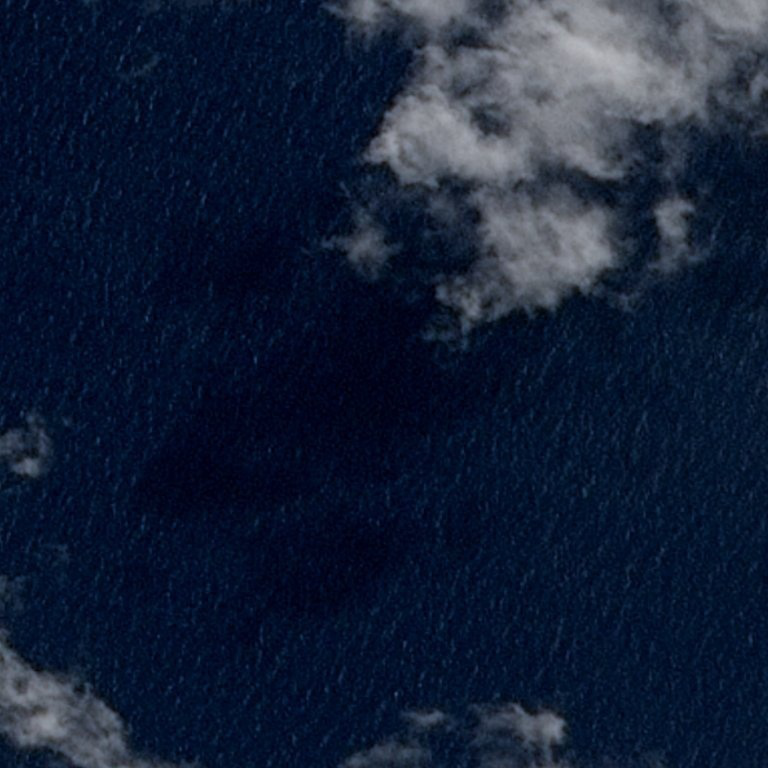

In [71]:
data
data.train_ds.x[1]


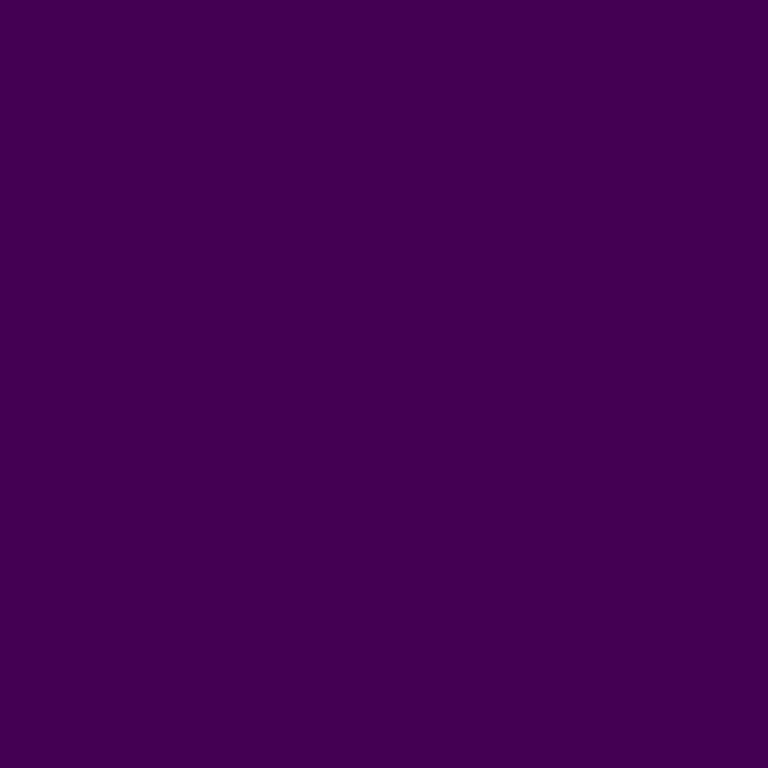

In [72]:
data.train_ds.y[1]


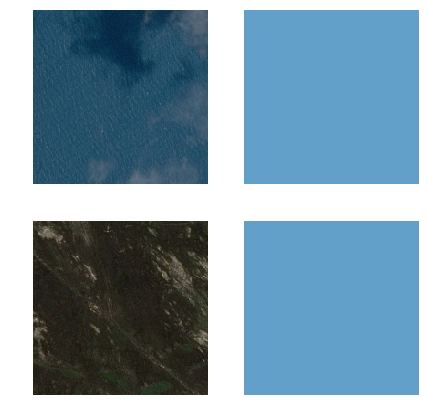

In [73]:
data.show_batch(2,figsize=(6,6), alpha=0.7)


In [74]:
data.classes


array(['NotShip', 'Ship'], dtype='<U7')

## Create Learner

In [75]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)
  

def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()
  
metrics = [dice_loss, accuracy_thresh, dice]

In [76]:
learn = unet_learner(data, models.resnet34, metrics=metrics)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 27487532.78it/s]


In [77]:
learn.loss_func = combo_loss

learn.loss_func, learn.metrics

(<function __main__.combo_loss(pred, targ)>,
 [<function __main__.dice_loss(input, target)>,
  <function fastai.metrics.accuracy_thresh(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.5, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x7fa34c16e730>>,
  <function fastai.metrics.dice(input:torch.Tensor, targs:torch.Tensor, iou:bool=False) -> <function NewType.<locals>.new_type at 0x7fa34c16e730>>])

In [78]:
print( gpu_mem_get() )

GPUMemory(total=11441, free=11014, used=427)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


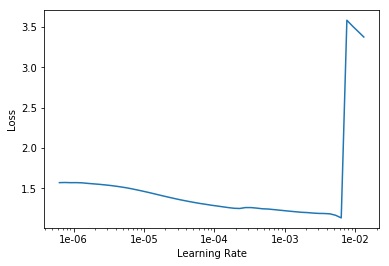

In [79]:
learn.lr_find()
learn.recorder.plot()


In [0]:
lr = 1e-3

In [58]:
learn.fit_one_cycle(10, max_lr=lr)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.378006,0.190425,0.186987,0.998910,0.703074,01:02
1,0.657330,0.203630,0.187298,0.998910,0.800000,01:02
2,0.418413,0.191486,0.186996,0.998910,0.678966,01:02
3,0.407628,0.197010,0.186989,0.998910,0.733903,01:02
4,0.332854,0.197652,0.187012,0.998910,0.660493,01:02
5,0.414735,0.188461,0.186980,0.998910,0.720039,01:02
6,0.368329,0.189380,0.186981,0.998910,0.736020,01:02
7,0.337652,0.188515,0.186980,0.998910,0.790876,01:02
8,0.367496,0.188023,0.186981,0.998910,0.794440,01:02
9,0.390956,0.188066,0.186986,0.998910,0.794259,01:02


In [0]:
learn.save('stage-1')

In [0]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics)


In [0]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


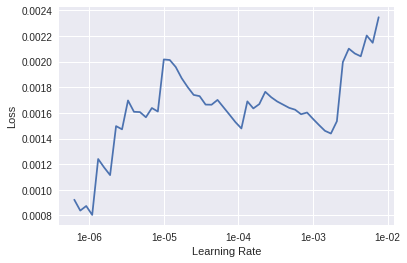

In [136]:
learn.lr_find()
learn.recorder.plot()

In [138]:
learn.fit_one_cycle(5, max_lr=1e-3)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.002394,0.006737,0.321419,0.998910,0.248321,00:48
1,0.134183,0.002146,0.416221,0.998910,0.736456,00:48
2,0.016853,0.003262,0.536993,0.998910,0.593024,00:49
3,0.004706,0.001890,0.466287,0.998910,0.648126,00:49
4,0.002442,0.001854,0.450329,0.998910,0.518596,00:49


## Model

In [0]:
#name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']
#void_code

def acc_ships(input, target):
    print( 'acc,  ' )
    #print( 'input original shape ', input.shape )
    #print( 'target before squeeze ', target.shape )
    target = target.squeeze(1)
    #print( 'target after squeeze ', target.shape )
    
    #mask = target != void_code
    #mask = target
    #print( 'input argmax dim=1 shape ', input.argmax(dim=1).shape )
    #print( 'final output acc_camvid shape ', (input.argmax(dim=1)==target).float().mean() )
    return (input.argmax(dim=1)==target).float().mean()

In [0]:
#metrics=acc_ships
metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd )#.to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 58248794.73it/s]


<class 'fastai.vision.image.Image'> <class 'torch.Tensor'>
torch.Size([3, 768, 768]) torch.Size([3, 768, 768])


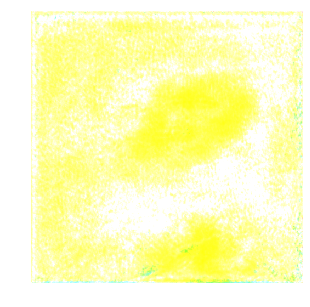

In [0]:
img = learn.data.train_ds[1][0]
pred = learn.predict(img)

print( type(pred[0]), type(pred[1]))
print( pred[0].shape , pred[1].shape  )


#show img and img evaluated on untrained model 
#img.show(figsize=(5,5), alpha=1)
pred[0].show(figsize=(5,5), alpha=1)

In [0]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [0]:
gc.collect()

22243

In [0]:
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.9)

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.389135,0.334715,0.896700
2,0.377873,0.324080,0.900284
3,0.369020,0.325073,0.904146
4,0.355022,0.308820,0.912556
5,0.351138,0.313001,0.909351
6,0.347777,0.285509,0.920183
7,0.338683,0.306076,0.909899
8,0.318913,0.303712,0.915792
9,0.312038,0.276126,0.920137
10,0.311217,0.276649,0.925244


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=3

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


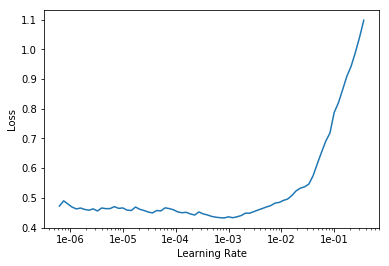

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

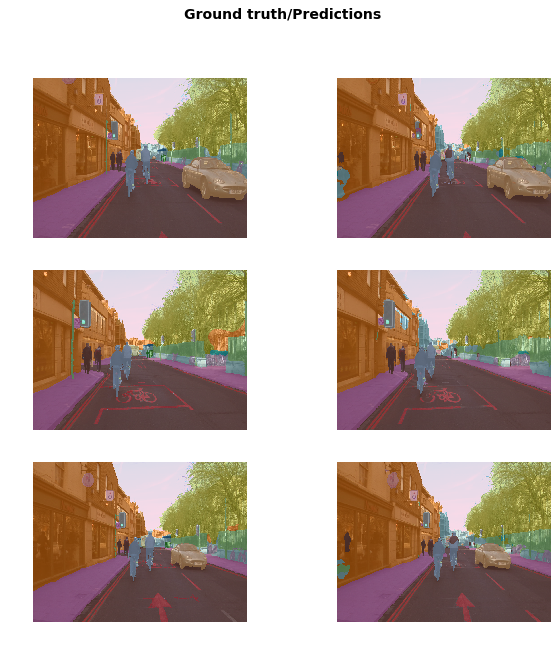

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin